In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#model Training
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate, cross_val_score

from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn import linear_model

import xgboost as xgb
from sklearn.metrics import mean_squared_error

#knn imputer
from sklearn.neighbors import KNeighborsRegressor

#feature filtering/processing
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestClassifier

#outliers
from sklearn.ensemble import IsolationForest

#plot tree
from sklearn.tree import plot_tree

#sns configuration
sns.set(style="ticks", color_codes=True)

#investigate data
pd.set_option('display.max_columns', None)

#dictionary
import collections

#display dataframe
from IPython.display import display

#hyperparameters tuning
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import statsmodels.regression.linear_model as smrlm
import statsmodels.api as sm
from scipy.stats import randint

import math

from graph_utils import *
from utils import *

# Knowledge

1. Fetus = which fetus is it (first fetus, second fetus)

In [2]:
#read csv
df_1112 = pd.read_excel('data/FGR_STUDY 20112012.xls', header=2)
df_1213 = pd.read_excel('data/FGR_STUDY 20122013.xls', header=2)
df_1314 = pd.read_excel('data/FGR_STUDY 20132014.xls', header=2)
df_1415 = pd.read_excel('data/FGR_STUDY 20142015.xls', header=2)
df_1516 = pd.read_excel('data/FGR_STUDY 20152016.xls', header=2)
df_1617 = pd.read_excel('data/FGR_STUDY 20162017.xls', header=2)
df_1718 = pd.read_excel('data/FGR_STUDY 20172018.xls', header=2)
df_1819 = pd.read_excel('data/FGR_STUDY 20182019.xls', header=2)
df_1920 = pd.read_excel('data/FGR_STUDY 20192020.xls', header=2)
df_2021 = pd.read_excel('data/FGR_STUDY 20202021.xls', header=2)

In [3]:
df_2021 = df_2021.rename(columns={'GA (WK)': ' (2)', 'GA (DAYS)': ' (3)'})

In [4]:
frames = [df_1112, df_1213, df_1314, df_1415, df_1516, df_1617, df_1718, df_1819, df_1920, df_2021]
df_master = pd.concat(frames)

In [5]:
#(2) is Gweek, (3) is Gday (I guess)
df_master['GA(day)'] = df_master[' (2)'] * 7 + df_master[' (3)']
df_master['GA(week)'] = df_master['GA(day)'] // 7

In [6]:
#drop some unecessary columns
df_master = df_master.drop([' (2)', ' (3)'], axis=1)

In [7]:
df_master = df_master[~df_master['EFW (clinical)'].isnull()]

In [8]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96510 entries, 0 to 16784
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       96510 non-null  int64         
 1   Case number               96510 non-null  int64         
 2   Exam                      96510 non-null  int64         
 3   Fetus                     96510 non-null  float64       
 4   Hospital no.              96510 non-null  object        
 5   Ethnic_group              265 non-null    object        
 6   BPD                       96348 non-null  float64       
 7   HC                        96468 non-null  float64       
 8   TCD                       25859 non-null  float64       
 9   AC                        96499 non-null  float64       
 10  CM                        21435 non-null  float64       
 11  FL                        96492 non-null  float64       
 12  Humerus           

## Personal Preprocessing

1. Removing features with <1000 non-null :
    - 4   Ethnic_group              265 non-null    object  
    - 26  A-wave                    359 non-null    object        
    - 27  Ductus Venosus PI         135 non-null    float64       
    - 28  TAV                       14 non-null     float64       
    - 29  Uterine artery PI  left   107 non-null    float64       
    - 30  Uterine artery PI  right  116 non-null    float64       
    - 31  RI left                   97 non-null     float64       
    - 32  RI right                  107 non-null    float64       
    - 33  Notch                     87 non-null     object        
    - 34  Funnelling                384 non-null    object        
    - 35  Cervix length             426 non-null    float64  
 
2. Correcting dtypes of:
    - Fetus                     96510 non-null  float64 >> int32
    - Presentation              95572 non-null  object >> category  
    - Placenta site             94756 non-null  object >> category  
    - Amniotic fluid            94511 non-null  object >> category
    - Cord                      34048 non-null  object >> category    
    
3. Remove fetus 2 (we only focus on singleton pregnancies)

In [9]:
#dropping mostly missing features
# df_master = df_master.drop(['Ethnic_group', 'A-wave', 'Ductus Venosus PI', 'TAV',
#                             'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
#                             'RI right', 'Notch', 'Funnelling', 'Cervix length',], axis=1)

#correcting dtypes
df_master['Fetus'] = df_master['Fetus'].astype('int32')
df_master['Presentation'] = df_master['Presentation'].astype('category')
df_master['Placenta site'] = df_master['Placenta site'].astype('category')
df_master['Amniotic fluid'] = df_master['Amniotic fluid'].astype('category')
df_master['Cord'] = df_master['Cord'].astype('category')

#removing fetus>1 mothers
patient_remove = list(df_master[df_master['Fetus'] > 1]['Hospital no.'].unique())
df_master = df_master[~df_master['Hospital no.'].isin(patient_remove)]

# Split into 3 seperate dataframe

Retrieved from 374 patients in previous df: 

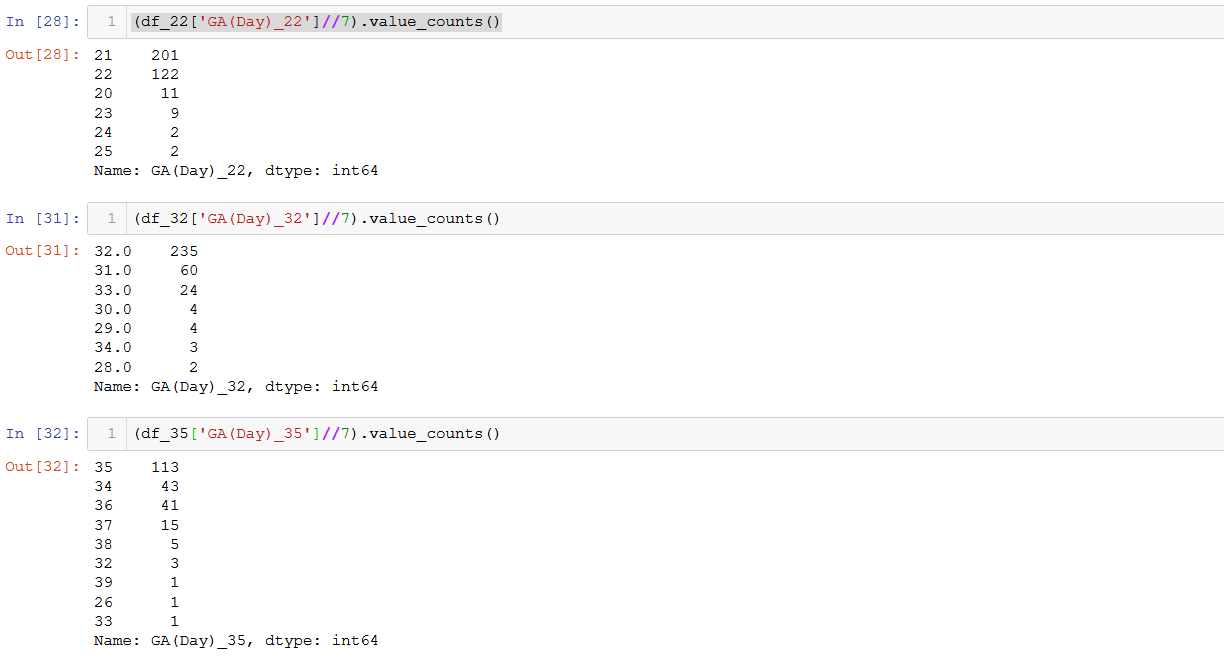

Basically:
1. Wk22 = <28 || Wk32 = 28 - 34 || Wk35 = >34
- get common hospital no. from each df, then filter.
- A patient not necessary has only 1 scan in each wk. - my idea here is that it's okay to more scan, because it will be used to forecast the same value in the other wk anyways.
    - So I think that the GA(week) of the forecasted week need to be an input of the model.
    - by using merge:
        - Let say patient A has 2 row of records in both wk22 and wk32. This will create 4 rows (each row in wk22 associated with each row in wk32)


In [10]:
def get_cat(week):
    '''
    Wk22 = <28 Wk32 = 28 - 34 Wk35 = >34
    '''
    
    if week < 28:
        return 'wk22'
    elif week > 34:
        return 'wk35'
    else:
        return 'wk32'

df_master['df_cat'] = df_master['GA(week)'].apply(lambda x: get_cat(x))

In [11]:
df_22, df_32, df_35 = df_master.groupby('df_cat')

In [12]:
df_new = df_master.groupby('df_cat')  
df_22 = df_new.get_group('wk22')
df_32 = df_new.get_group('wk32')
df_35 = df_new.get_group('wk35')

In [13]:
no_22 = set(df_22['Hospital no.'].unique())
no_32 = set(df_32['Hospital no.'].unique())
no_35 = set(df_35['Hospital no.'].unique())

In [14]:
common_no = no_22.intersection(no_32).intersection(no_35)

In [15]:
df_32[df_32['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13122,19636,1,4,1,01036335,NaN,70.1,266.1,NaN,245.4,NaN,52.2,NaN,1228.0,40.5,NaN,cephalic,anterior high,12.3,normal,NaN,0.93,0.62,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-29,NaN,NaN,NaN,NaN,202.0,28.0,wk32
13120,19636,1,5,1,01036335,NaN,76.5,287.6,NaN,282.1,NaN,61.3,NaN,1864.0,46.4,NaN,cephalic,anterior high,12.4,normal,NaN,0.82,0.57,positive,1.76,0.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,33.0,Hadlock (BPD-HC-AC-FL),2016-04-19,NaN,NaN,NaN,NaN,223.0,31.0,wk32
2697,11013,1,2,1,01059564,NaN,73.6,264.7,NaN,246.3,NaN,50.7,NaN,1214.0,48.1,NaN,Variable,posterior high,28.0,polyhydramnios,NaN,1.34,0.75,NaN,2.15,0.94,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-07-08,NaN,NaN,NaN,NaN,200.0,28.0,wk32
2696,11013,1,3,1,01059564,NaN,84.7,304.0,NaN,295.3,NaN,61.8,NaN,2136.0,62.0,NaN,cephalic,posterior high,29.4,polyhydramnios,NaN,1.05,0.68,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-08-05,NaN,NaN,NaN,NaN,228.0,32.0,wk32
3298,1630,1,2,1,01067818,NaN,81.6,301.4,NaN,282.9,NaN,66.6,NaN,2110.0,27.6,NaN,cephalic,Placenta praevia,14.7,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-01-29,NaN,NaN,NaN,NaN,236.0,33.0,wk32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,43097,1,2,1,36060333,NaN,87.8,312.1,NaN,315.3,NaN,65.6,NaN,2559.0,86.2,NaN,cephalic,anterior high,16.0,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,233.0,33.0,wk32
14641,43461,1,2,1,36066718,NaN,71.2,257.3,NaN,238.2,NaN,53.4,NaN,1191.0,24.6,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,positive,NaN,NaN,1.92,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-07,0.91,0.62,1.75,0.79,204.0,29.0,wk32
14642,43461,1,3,1,36066718,NaN,76.6,276.5,NaN,248.3,NaN,56.7,53.1,1408.0,14.3,NaN,cephalic,anterior high,10.6,normal,3 vessels,NaN,NaN,positive,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-19,0.99,0.63,NaN,NaN,216.0,30.0,wk32
14431,43391,1,2,1,36067895,NaN,84.5,313.4,NaN,299.2,NaN,56.0,53.6,2045.0,21.6,NaN,cephalic,posterior high,7.1,reduced,NaN,NaN,NaN,positive,NaN,NaN,2.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-04-26,0.65,0.49,1.52,NaN,236.0,33.0,wk32


In [16]:
df_22[df_22['Hospital no.'].isin(common_no)].sort_values(['Hospital no.', 'Examination date'], ascending=[True, True])

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,A-wave,Ductus Venosus PI,TAV,Uterine artery PI left,Uterine artery PI right,RI left,RI right,Notch,Funnelling,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
13123,19636,1,2,1,01036335,NaN,46.6,173.5,20.5,161.8,2.4,34.8,NaN,390.0,NaN,NaN,transverse,anterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.74,NaN,0.5,no notch,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-02-02,NaN,NaN,NaN,NaN,146.0,20.0,wk22
13118,19636,1,3,1,01036335,NaN,59.5,230.4,NaN,198.7,NaN,44.7,NaN,719.0,29.6,NaN,transverse,anterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-03-01,NaN,NaN,NaN,NaN,174.0,24.0,wk22
2698,11013,1,1,1,01059564,NaN,50.7,187.4,21.4,151.4,4.3,36.9,35.6,393.0,NaN,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-05-21,NaN,NaN,NaN,NaN,152.0,21.0,wk22
2000,1630,1,1,1,01067818,NaN,63.3,250.8,NaN,214.5,NaN,48.3,NaN,897.0,36.2,NaN,cephalic,posterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-12-11,NaN,NaN,NaN,NaN,187.0,26.0,wk22
9225,12763,1,1,1,01080296,NaN,51.4,190.0,NaN,170.0,NaN,38.4,NaN,469.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-09-17,NaN,NaN,NaN,NaN,151.0,21.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16223,43200,1,1,1,36054730,NaN,51.3,192.4,23.7,184.0,5.8,39.7,36.2,536.0,NaN,150.0,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-16,NaN,NaN,NaN,NaN,163.0,23.0,wk22
16133,43097,1,1,1,36060333,NaN,72.7,272.6,NaN,249.1,NaN,51.0,47.4,1252.0,87.5,NaN,transverse,anterior high,24.0,increased,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-02-03,NaN,NaN,NaN,NaN,193.0,27.0,wk22
14643,43461,1,1,1,36066718,NaN,64.2,235.3,31.1,215.3,4.3,50.1,NaN,918.0,37.7,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,no,26.0,Hadlock (BPD-HC-AC-FL),2021-03-22,NaN,NaN,NaN,NaN,188.0,26.0,wk22
14433,43391,1,1,1,36067895,NaN,69.1,255.4,34.5,247.0,NaN,49.6,NaN,1160.0,68.0,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2021-03-15,NaN,NaN,NaN,NaN,194.0,27.0,wk22


# Visualization

In [17]:
def visualize_val_edit(value_cols, df_22, df_32, df_35, hue=None):
    for i in range(len(section)-1):
        cols = value_cols[section[i]: section[i+1]]
        fig, ax = plt.subplots(len(cols), 3, figsize=(35,35))
        for index, col in enumerate(cols):
            sns.set_palette('flare')
            a = sns.boxplot(x=col, data=df_22, ax=ax[index, 0], hue=hue)
            a.set_xlabel('', fontsize = 20.0) # X label
            a.set_ylabel(col, fontsize=20.0)
            a.tick_params(labelsize=20)

            sns.set_palette("pastel")
            b = sns.boxplot(x=col, data=df_32, ax=ax[index, 1], hue=hue)
            b.set_xlabel('', fontsize = 20.0) # X label
            b.set_ylabel('', fontsize=20.0)
            b.tick_params(labelsize=20)

            sns.set_palette("muted")
            c = sns.boxplot(x=col, data=df_35, ax=ax[index, 2], hue=hue)
            c.set_xlabel('', fontsize = 20.0) # X label
            c.set_ylabel('', fontsize=20.0)
            c.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()
    
def visualize_cat(cols, df_22, df_32, df_35, hue=None):
    '''visulizing categorical data'''
    fig, ax = plt.subplots(len(cols) , 3, figsize=(35,25))

    for index, col in enumerate(cat_cols):
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_22, ax=ax[index, 0], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel(col, fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)
        
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_32, ax=ax[index, 1], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel('', fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)
        
        sns.set_palette("pastel")
        b = sns.countplot(y=col, data=df_35, ax=ax[index, 2], hue=hue)
        b.set_xlabel('', fontsize = 20.0) # X label
        b.set_ylabel('', fontsize = 20.0) # Y label
        b.tick_params(labelsize=20)

    fig.tight_layout()
    plt.show()

sns.set_palette('flare')
value_cols = df_master.select_dtypes(include=['float64']).columns
cat_cols = df_master.select_dtypes(include=['category']).columns

In [18]:
section = [math.ceil(i) for i in np.linspace(start = 0, stop = len(value_cols), num = 5)]

In [19]:
df_22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26603 entries, 5 to 16782
Data columns (total 46 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   PID                       26603 non-null  int64         
 1   Case number               26603 non-null  int64         
 2   Exam                      26603 non-null  int64         
 3   Fetus                     26603 non-null  int32         
 4   Hospital no.              26603 non-null  object        
 5   Ethnic_group              77 non-null     object        
 6   BPD                       26585 non-null  float64       
 7   HC                        26588 non-null  float64       
 8   TCD                       21012 non-null  float64       
 9   AC                        26602 non-null  float64       
 10  CM                        19623 non-null  float64       
 11  FL                        26601 non-null  float64       
 12  Humerus           

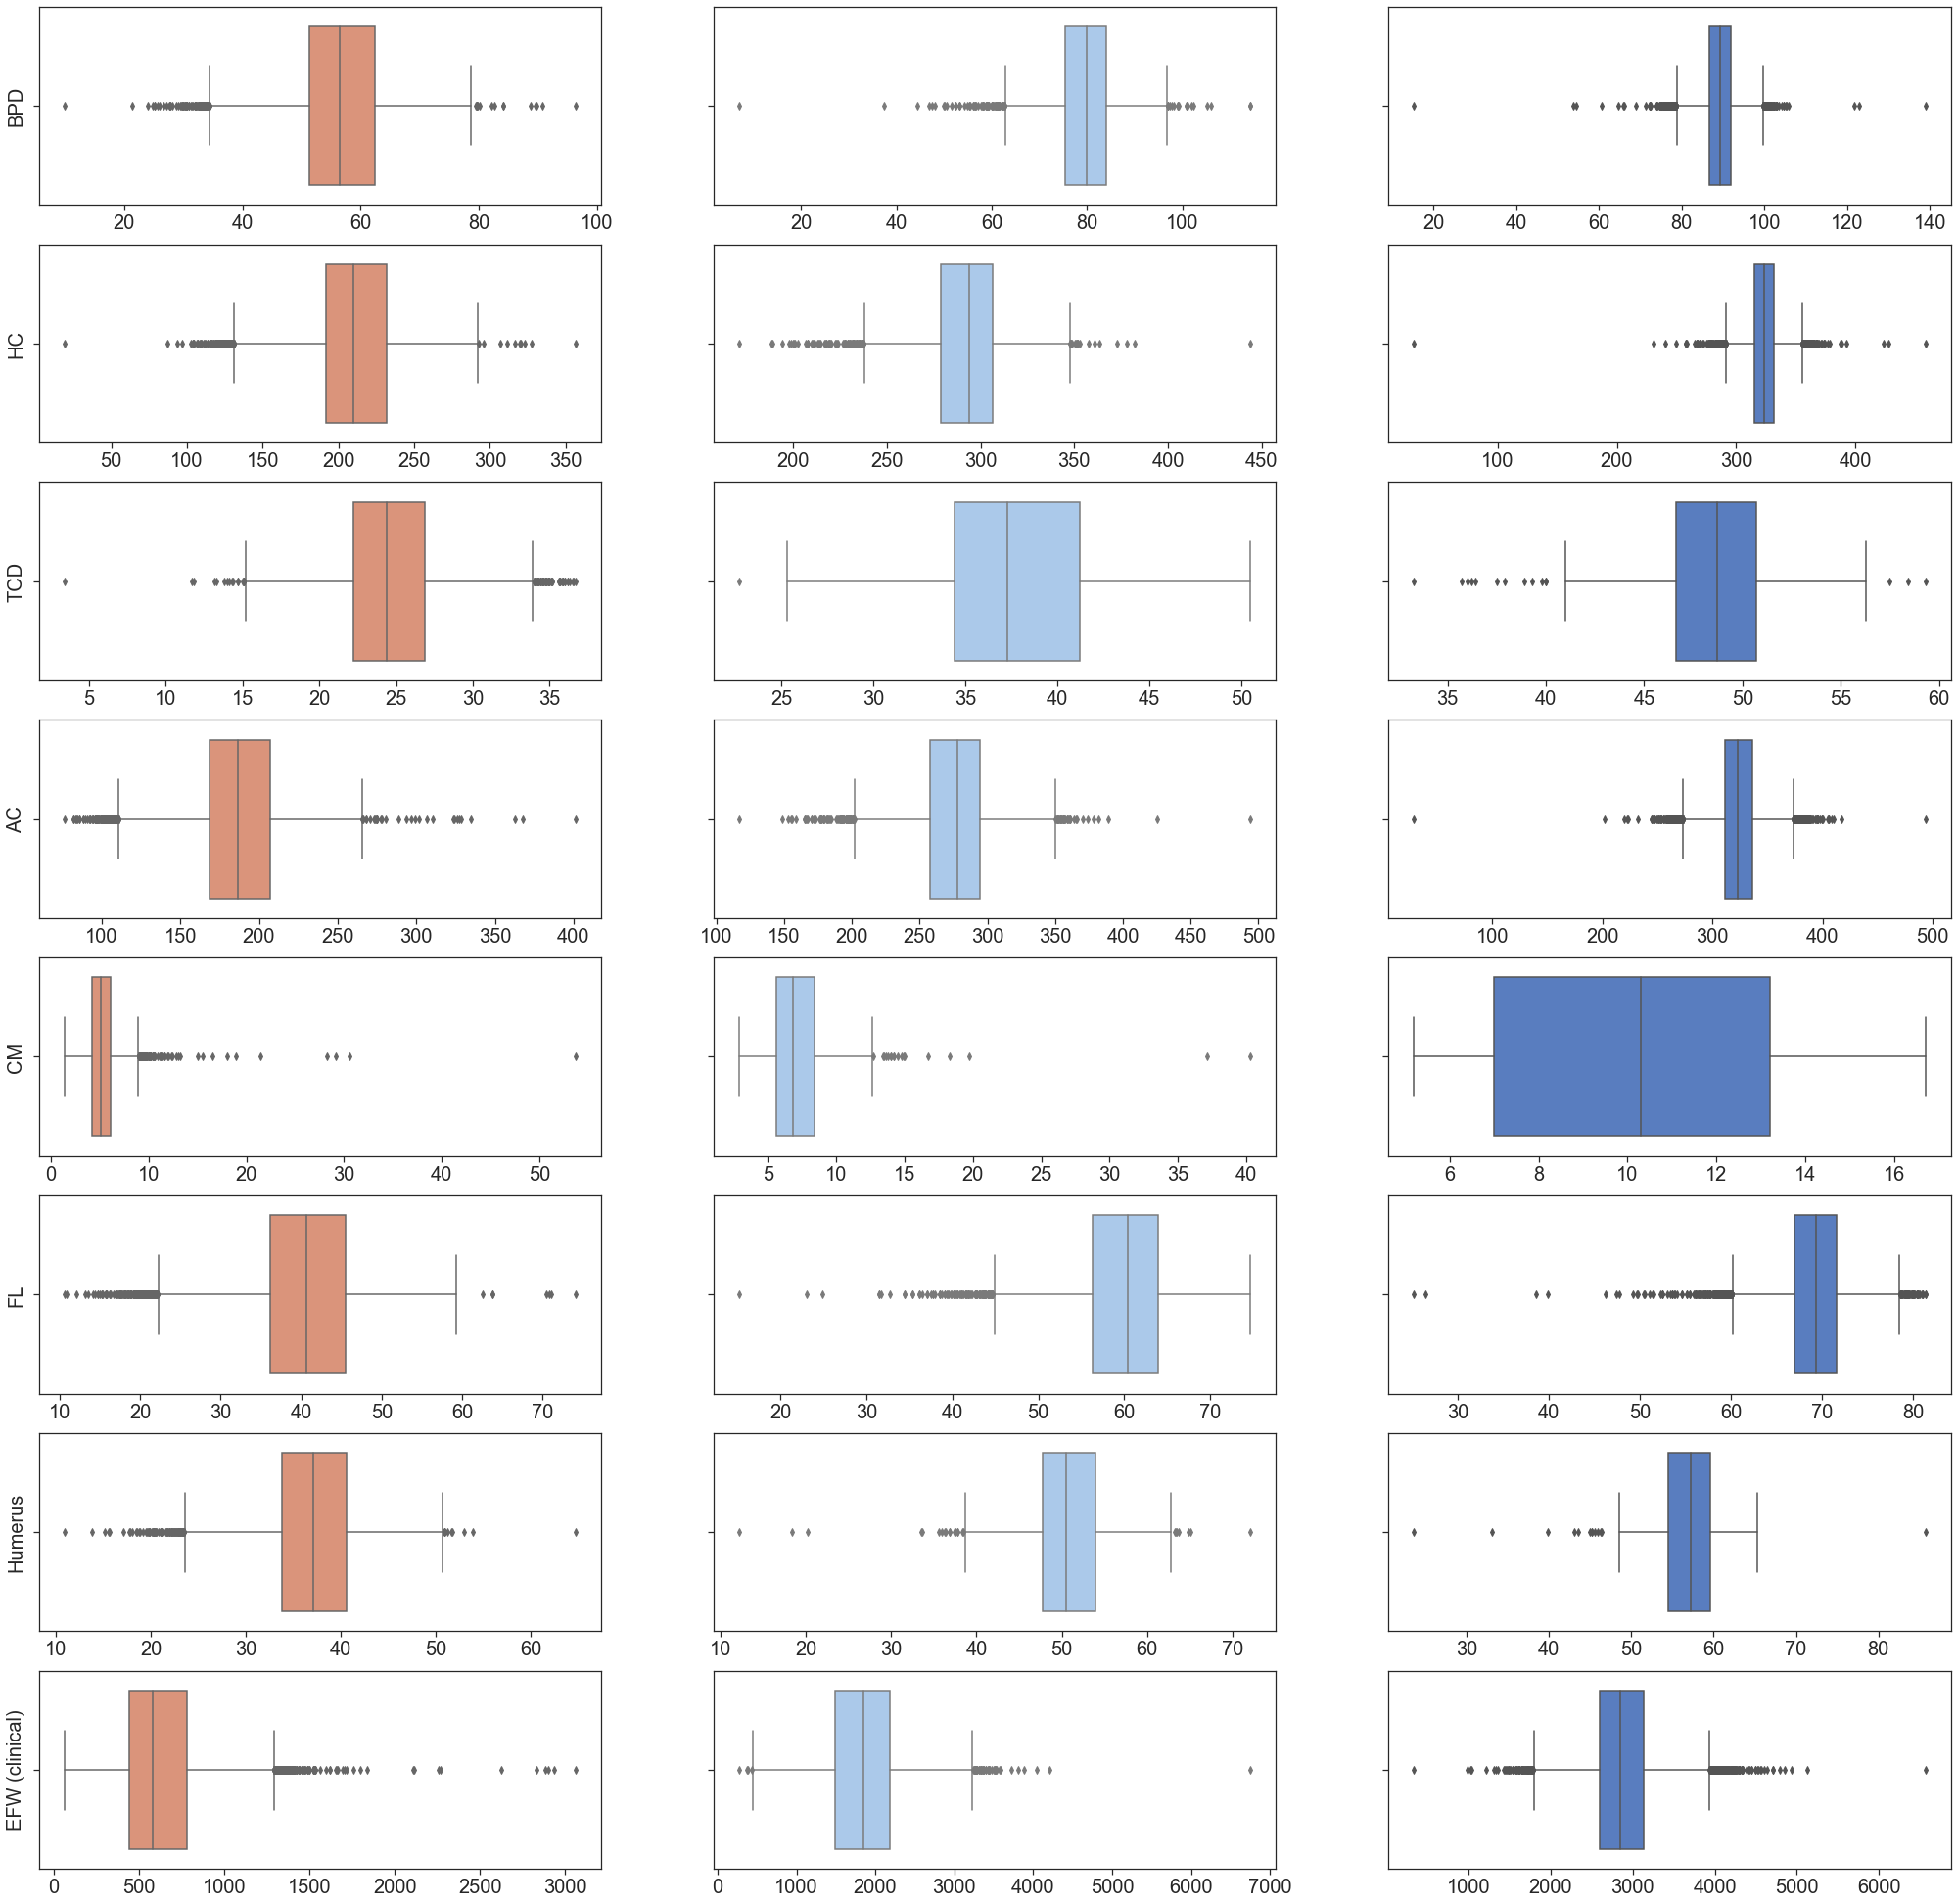

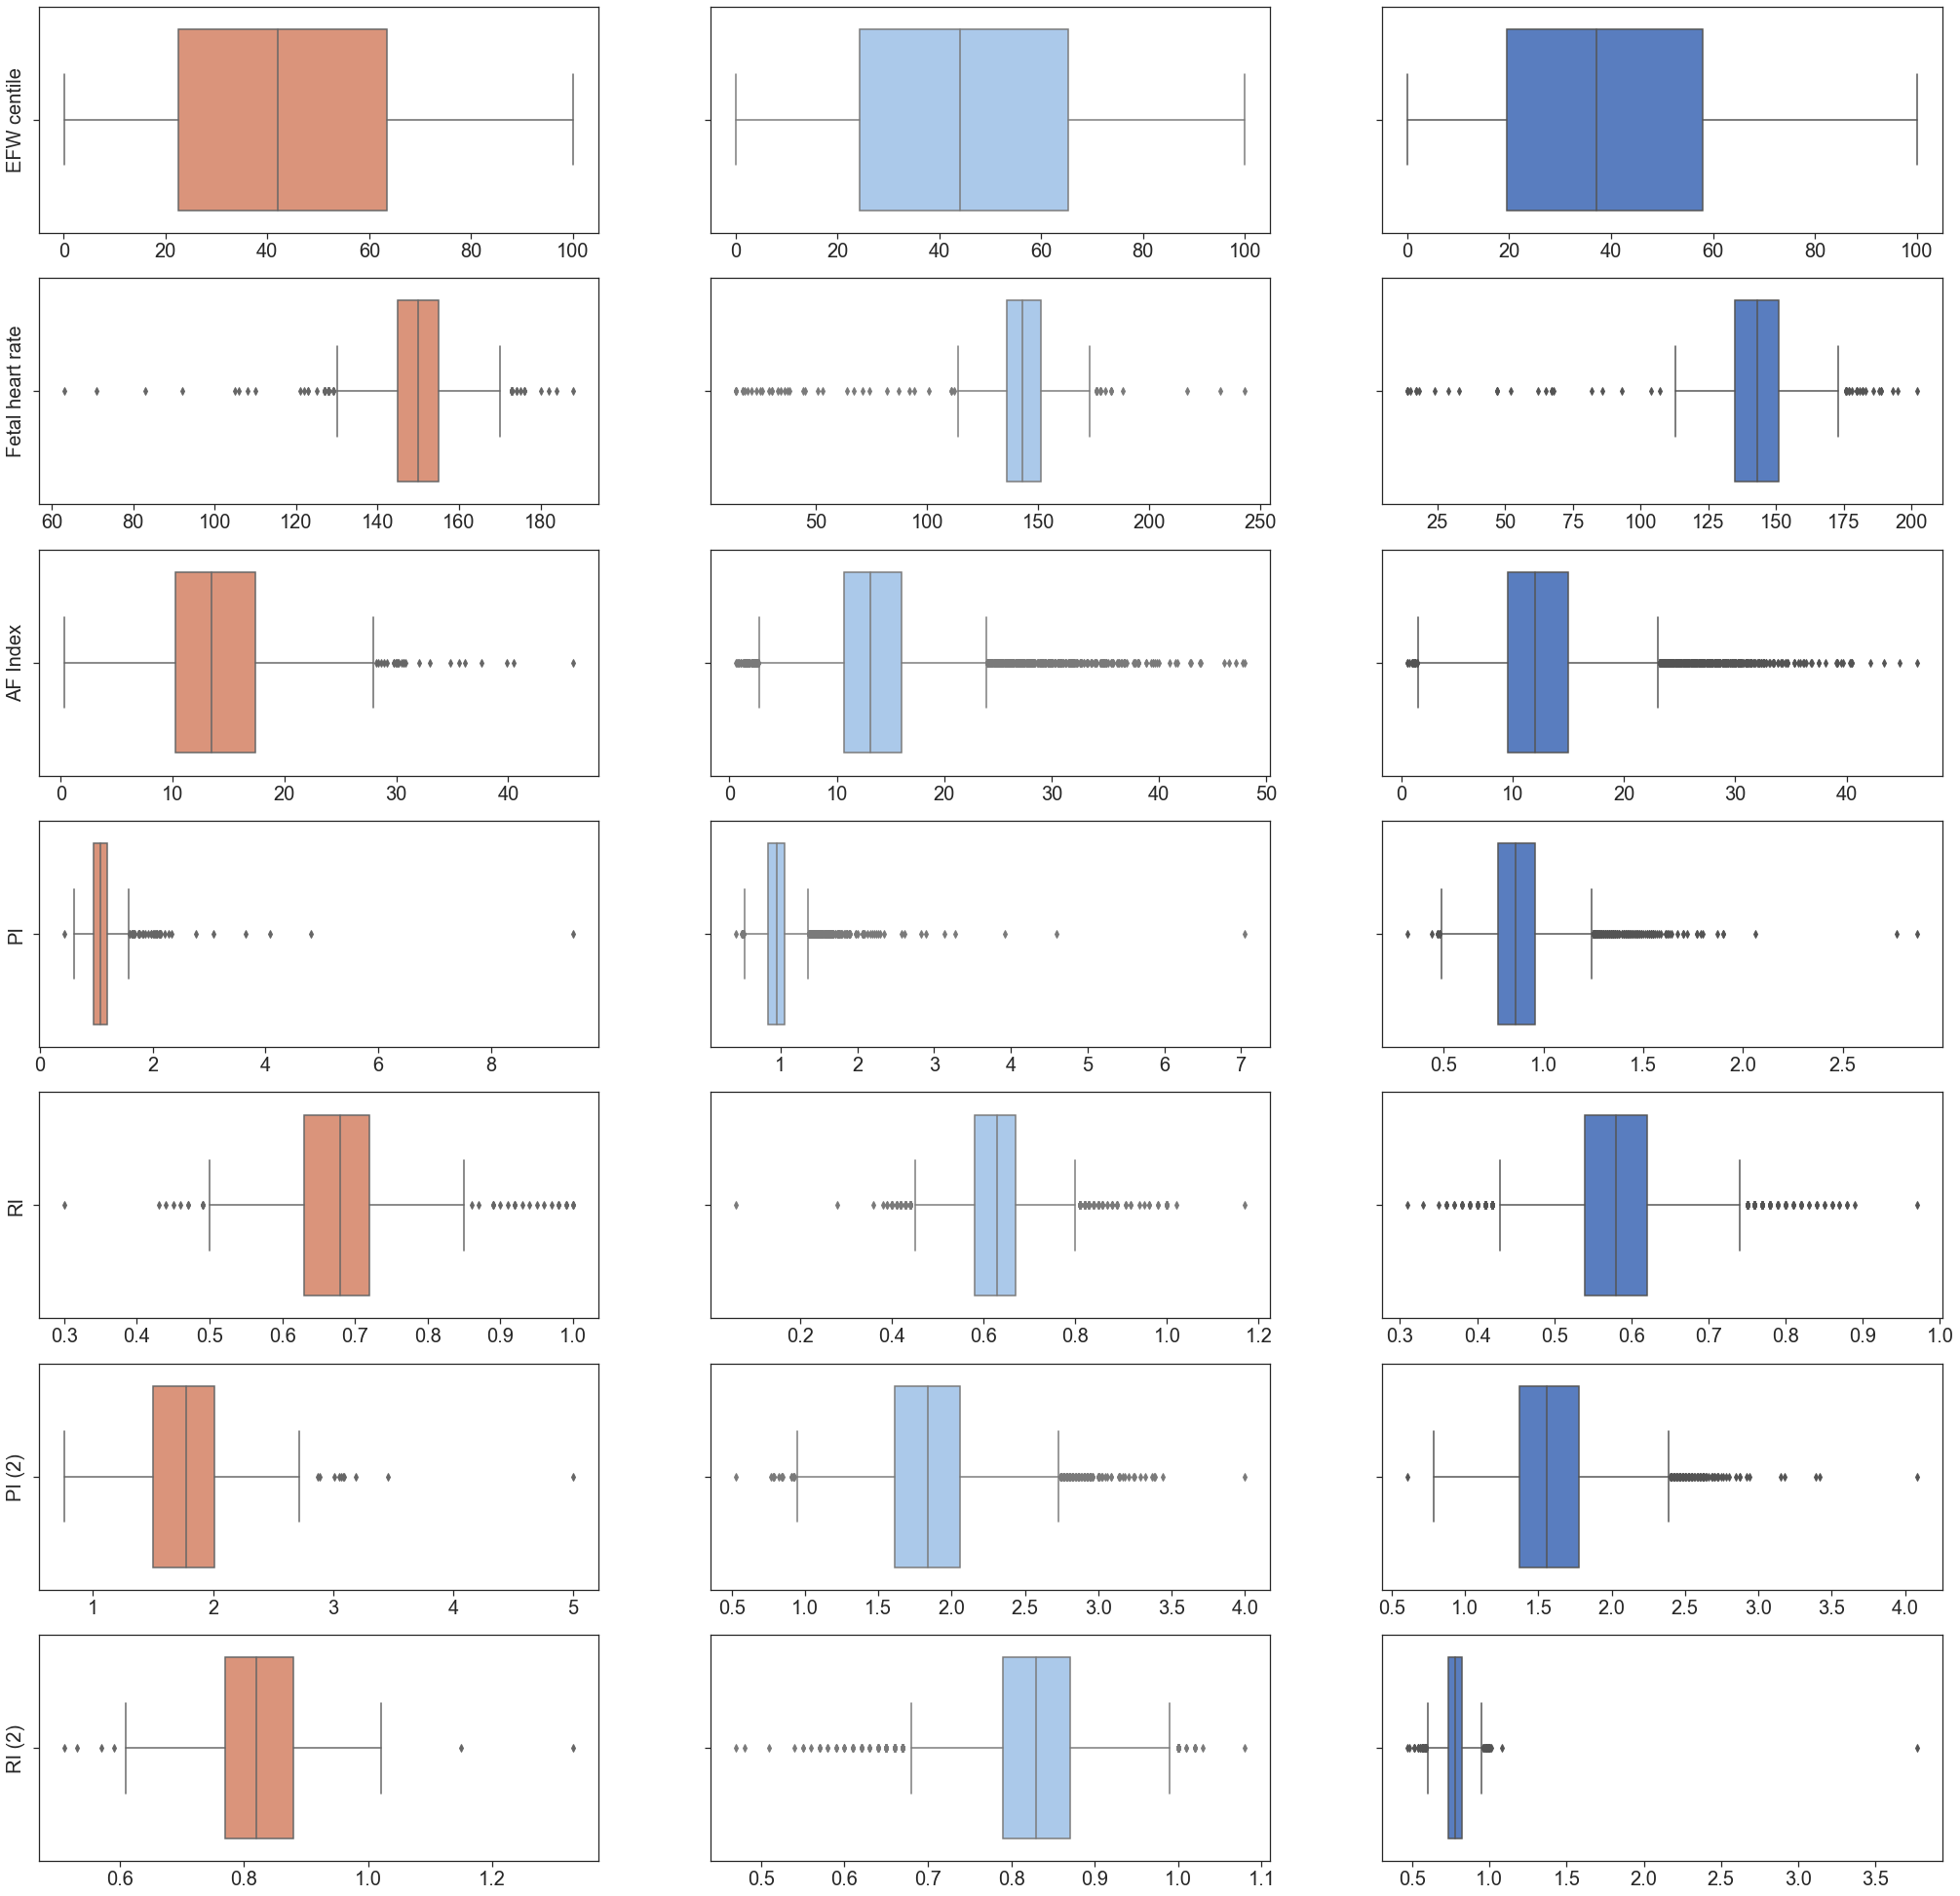

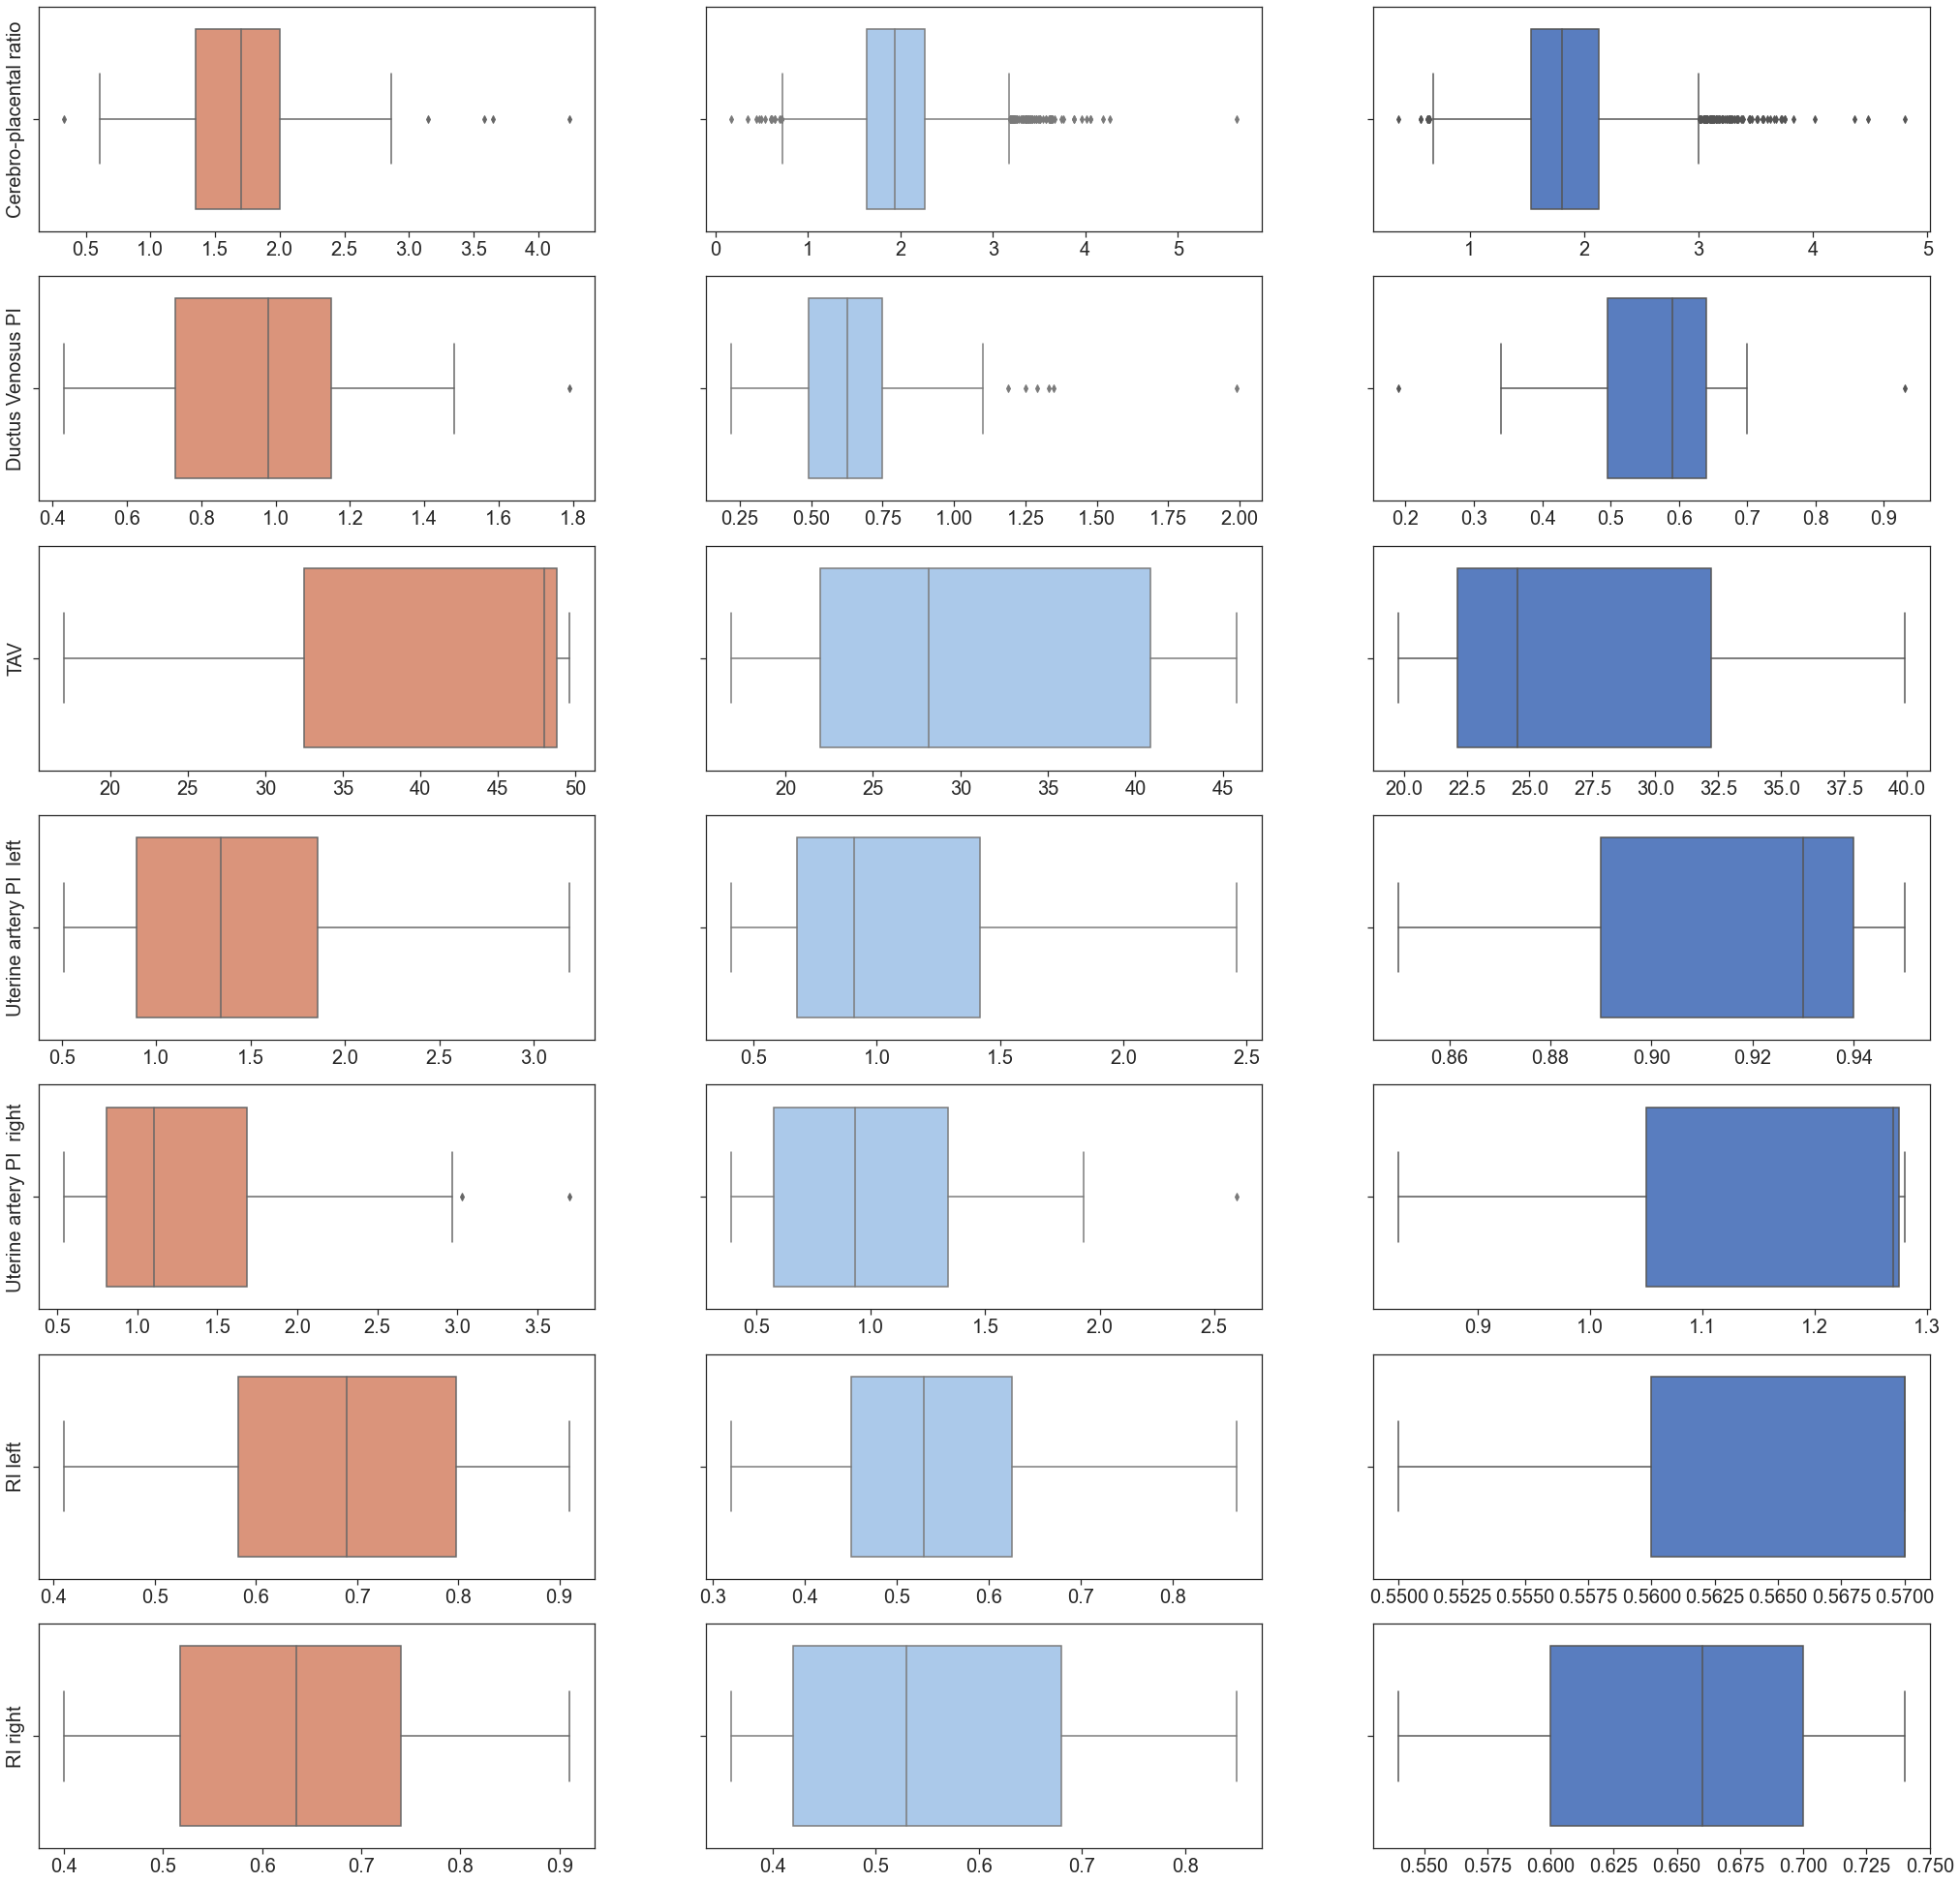

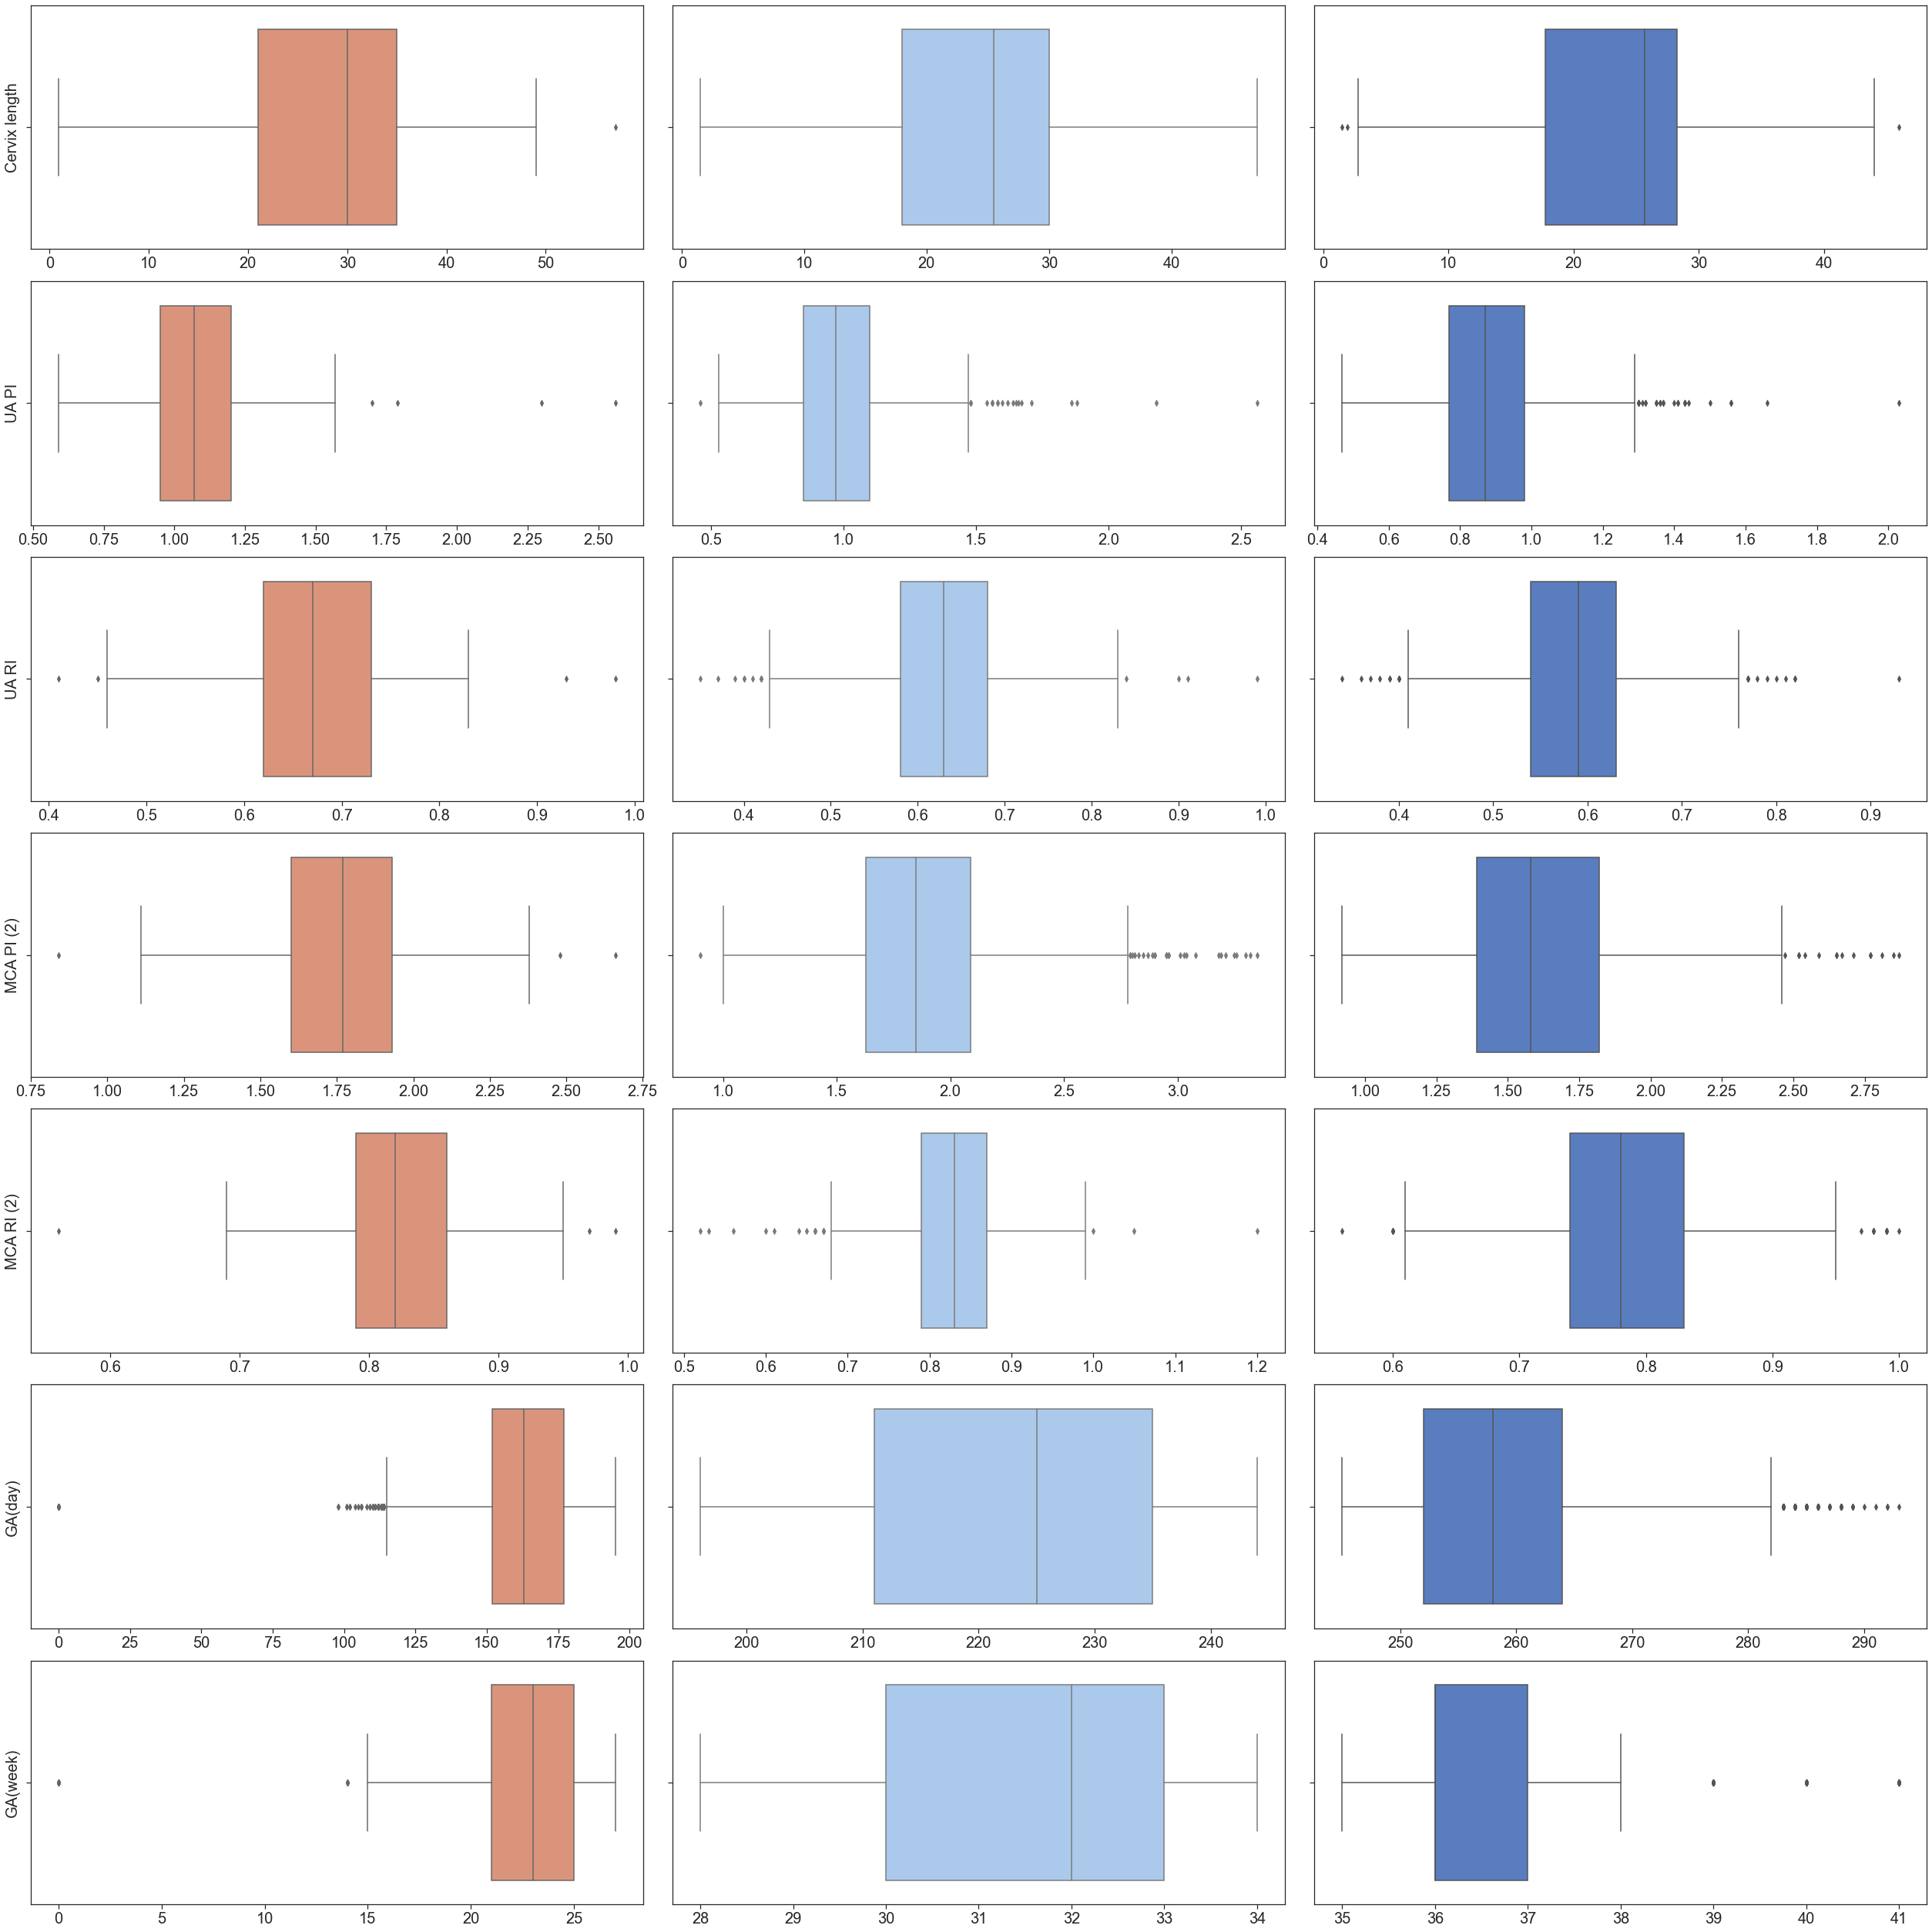

In [20]:
#wk22 --- wk32 --- wk35
visualize_val_edit(value_cols, df_22, df_32, df_35)

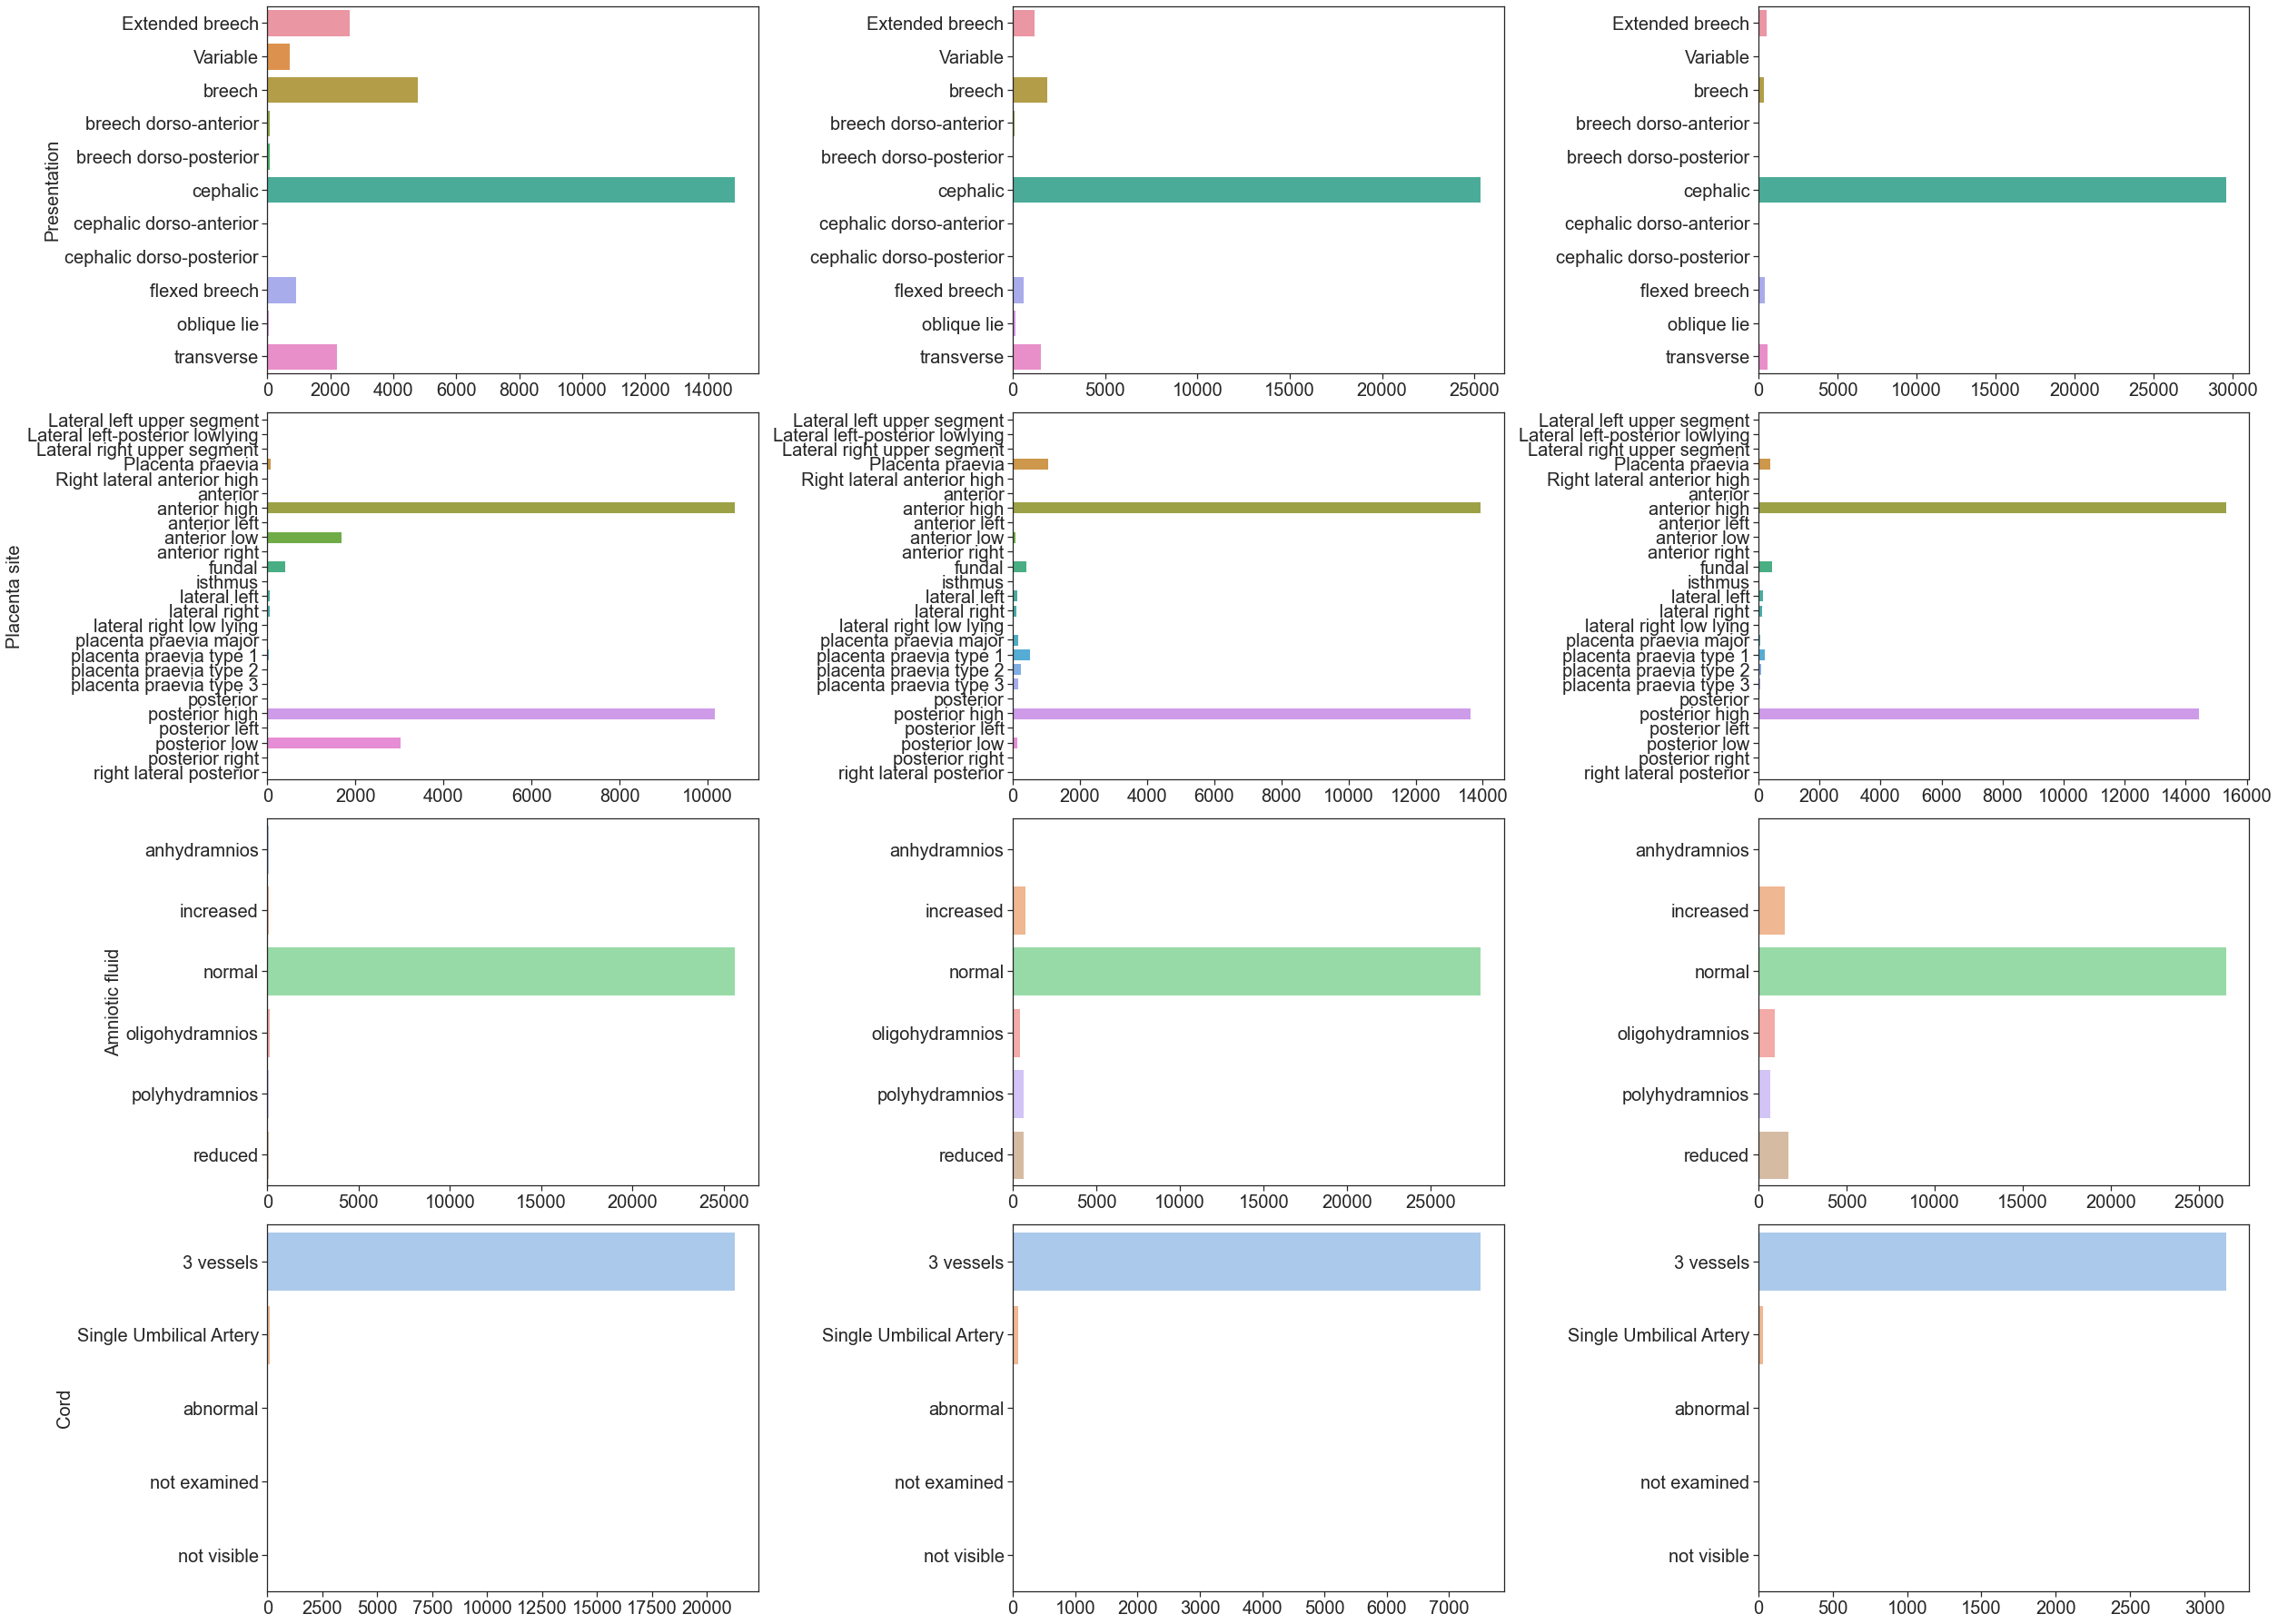

In [21]:
#MAKE EFW IN BIN FIRST BEFORE HUEING
visualize_cat(cat_cols, df_22, df_32, df_35)

### Summary:

From wk22 > wk32 > wk35: Float columns

1. Increasing:
	- BPD (55|80|90) 
        - the diameter of your baby's head/ The biparietal diameter (BPD) is measured as an outer-to-inner cranial measurement
	- HC  (210|290|320) 
        -  The occipitofrontal diameter (OFD) as the distance between the middle of the bone echoes. The head circumference is calculated by the formula: HC = 1.62 × (BPD + OFD).
	- TCD (24|37|48)
        - Fetal transverse cerebellar diameter
        - It is measured as the maximal diameter between the cerebellar hemispheres on an axial scan.
        - Is it hem in previous study?
	- AC  (180|275|320)
         - abdominal circumference -> circumference of the fetal abdomen (body space between the chest and pelvis)
	- CM  (5|7|10)
        - cisterna magna is the space between the inferior margin of the vermis and the posterior rim of the foramen magnum
        - Inferior margin –> inferior border. The caudal or lowermost margin of a structure.
        - Vermis is the unpaired, median portion of the cerebellum that connects the two hemispheres （小脑）
        - Posterior -> further back in position; of or nearer the rear or hind end.
        - Foramen magnum is the largest foramen of the skull
        - In short it is the space between those 2 things at the skull.
	- FL  (40|60|70) 
        - Femur length (FL) -> Measures the longest bone in the body and reflects the longitudinal growth of the fetus.
	- Humerus (38|50|58)
        - Humerus is the arm bone between your shoulder and your elbow.
	- EFW (600|1850|2900)
        - Estimated Fetal Weight
	- Cerebro-placental ratio (1.75|2|1.9)
        - Cerebroplacental ratio (CPR) is an obstetric ultrasound tool used as a predictor of adverse pregnancy outcome in both small for gestational age (SGA) and appropriate for gestational age (AGA) fetuses.
        - 
	- GA(day) (160|225|258)
	- GA(week) (23|32|36.5)
    
    
2. Remain:
	- EFW centile (40|40|40)
	- Uterine artery PI left (1.35|0.9|0.93)
        - Uterus's artery
        - Pulsatility index (PI) (also known as the Gosling index) is a calculated flow parameter in ultrasound, derived from the maximum, minimum, and mean Doppler frequency shifts during a defined cardiac cycle.
        - A high uterine artery pulsatility index reflects a defective development of placental bed spiral arteries in pregnancies complicated by hypertension and fetal growth retardation.
        
        - The mean PI in the right and left uterine artery are 1.09 and 0.81, with a range of 0.53 - 1.58 and 0.58 - 1.83 respectively. The RI has a mean of 0.59 and 0.65, while the range was 0.37-1.16 and 0.41 - 0.82 in both the right and left uterine artery respectively.
        
	- Ductus Veneous PI (1|0.625|0.6)
        - A shunt that allows oxygenated blood in the umbilical vein to bypass the liver and is essential for normal fetal circulation.
        - In medicine, a shunt is a hole or a small passage which moves, or allows movement of, fluid from one part of the body to another.
	- RI(2) (0.82|0.83|0.75)
        - Resistance Index is a measure of pulsatile blood flow that reflects the resistance to blood flow caused by microvascular bed distal to the site of measurement.
    
    
3. Decreasing:
	- Fetal heart rate (150|145|140)
	- AF index (13|12|12)
        - The sum of the deepest vertical pocket of fluid.
        - A normal amniotic fluid index is 5 cm to 25 cm using the standard assessment method. Less than 5 cm is considered oligohydramnios, and greater than 25 cm is considered polyhydramnios.
	- PI (1|1|0.9)
        - Pulsatility index
	- RI (0.68|0.62|0.58)
        - Resistance index
	- PI(2) (1.9|1.8|1.6)
	- TAV (47|28|24)
        - time-averaged velocity
        - https://radiopaedia.org/articles/umbilical-arterial-doppler-assessment
        - umbilical arterial S/D ratio (SDR): systolic velocity / diastolic velocity
        - pulsatility index (PI) (Gosling index): (PSV - EDV) / TAV
        - resistive index (RI) (Pourcelot index): (PSV - EDV) / PSV
        - PSV: peak systolic velocity
        - EDV: end-diastolic velocity
        - TAV: time-averaged velocity

	- Cervix Length (30|26|28)
        - A cylinder-shaped neck of tissue that connects the vagina and uterus.
	- UA PI (1.1|0.95|0.9)
        - Uterine Artery Pusatility index(mentioned before)
	- UA RI (0.68|0.62|0.59)
        - Uterine Artery Resistance index
	- MCA PI(2) (1.8|1.9|1.6)
        - Fetal middle cerebral arterial (MCA) Doppler assessment is an important part of assessing fetal cardiovascular distress, fetal anemia or fetal hypoxia.
	- MCA RI(2) (0.82|0.82|0.78)
    
    
4. Unclear:
	- Uterine artery PI right (1.1|0.95|1.28)
	- RI right (0.62|0.53|0.66)
	- RI left (0.7|0.52|0.565)
    
From wk22 > wk32 > wk35: Category columns

1. Presentation: The way that the fetus presented.
     - Extended breech, variable, breech, flexed breech and transverse mostly become cephalic

- Placenta site:
     - posterior low, anterior low become less, placenta praevia increase then decrease.

- Amniotic fluid:
     - Gradually become more variations

- Cord:
     - Remain 3 Vessels 
         - baby's “supply line” because it carries the baby's blood back and forth, between the baby and the placenta.
	

## Comparing to previous data

|Prev | Now |
|-|-|
| EFW_22 | EFW (Clinical) |
| GA(Day)_22 | GA(day) |
| Baby Gender_22 | None |
| CM_22 | CM |
| Ut PI_22 | UA PI / left / right |
| Va_22 | None |
| Nuchal fold_22 | None |
| Hem_22 | TCD |
| BPD_22 | BPD |
| GA(Week)_32 | Yes |
| EFW_32 | Yes |

In [22]:
df_master.columns

Index(['PID', 'Case number', 'Exam', 'Fetus', 'Hospital no.', 'Ethnic_group',
       'BPD', 'HC', 'TCD', 'AC', 'CM', 'FL', 'Humerus', 'EFW (clinical)',
       'EFW centile', 'Fetal heart rate', 'Presentation', 'Placenta site',
       'AF Index', 'Amniotic fluid', 'Cord', 'PI', 'RI', 'EDF', 'PI (2)',
       'RI (2)', 'Cerebro-placental ratio', 'A-wave', 'Ductus Venosus PI',
       'TAV', 'Uterine artery PI  left', 'Uterine artery PI  right', 'RI left',
       'RI right', 'Notch', 'Funnelling', 'Cervix length',
       'Estimated fetal weight', 'Examination date', 'UA PI', 'UA RI',
       'MCA PI (2)', 'MCA RI (2)', 'GA(day)', 'GA(week)', 'df_cat'],
      dtype='object')

In [23]:
columns_to_drop = ['PID', 'Case number', 'Exam', 'Fetus','Hospital no.', 'EFW centile', ]

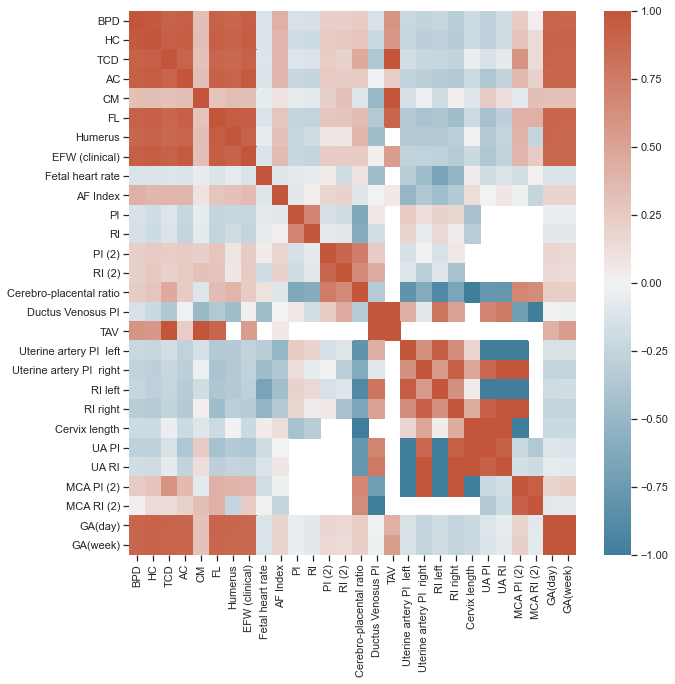

In [24]:
# correlation graph
f, ax = plt.subplots(figsize=(10,10))
corr = df_22.drop(columns_to_drop, axis=1).corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap)

#From the correlation graph:
#1. Removed Highly Correlated features with non-target
#2. Understand that none of the features has high correlation with target.

# Mergingg
1. Rename
- Take Hospital no., GA(week) and EFW(clinical) of respective week 
    - Wk22 + GA(Week)32 -> EFW wk32
    - Wk22 + GA(Week)35 -> EFW wk35
    - WK32 + GA(Week)32 -> EFW wk32
    
- Remove not null < 400
- Get non-null columns of the most common features (~20000 non-null)
- Remove not null again < 400
- Clean Category

In [52]:
df_22

,PID,Case number,Exam,Fetus,Hospital no.,Ethnic_group,BPD,HC,TCD,AC,...,Cervix length,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day),GA(week),df_cat
5,16,1,1,1,31146923,NaN,46.8,168.6,21.4,156.1,...,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,149.0,21.0,wk22
10,23,1,1,1,31173766,NaN,50.5,195.7,21.6,168.4,...,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
18,30,1,1,1,29779790,NaN,50.7,191.7,23.3,168.6,...,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,155.0,22.0,wk22
22,34,1,1,1,27591077,NaN,46.8,175.1,22.2,151.6,...,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,145.0,20.0,wk22
27,38,1,1,1,12350378,NaN,51.2,190.7,22.1,163.8,...,NaN,Hadlock (BPD-HC-AC-FL),2012-10-11,NaN,NaN,NaN,NaN,142.0,20.0,wk22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16770,43833,1,1,1,36156922,NaN,47.1,174.7,20.9,162.3,...,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,148.0,21.0,wk22
16771,43834,1,1,1,13274179,NaN,46.3,171.1,20.1,156.0,...,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,142.0,20.0,wk22
16772,43835,1,1,1,31646831,NaN,50.3,175.0,19.5,150.3,...,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,136.0,19.0,wk22
16773,43836,1,1,1,34500839,NaN,52.3,195.2,24.9,178.9,...,NaN,Hadlock (BPD-HC-AC-FL),2021-05-05,NaN,NaN,NaN,NaN,156.0,22.0,wk22


In [25]:
df_32_output = df_32[['Hospital no.', 'GA(week)', 'EFW (clinical)']]
df_35_output = df_35[['Hospital no.', 'GA(week)', 'EFW (clinical)']]

df_32_output = df_32_output.rename(columns={'GA(week)': 'GA(week)_32', 'EFW (clinical)': 'EFW_32'})
df_35_output = df_35_output.rename(columns={'GA(week)': 'GA(week)_32', 'EFW (clinical)': 'EFW_32'})

In [26]:
df_22_32 = pd.merge(df_22, df_32_output, on='Hospital no.', how='inner')
df_22_35 = pd.merge(df_22, df_35_output, on='Hospital no.', how='inner')

df_32_35 = pd.merge(df_32, df_35_output, on='Hospital no.', how='inner')

In [27]:
null_threshold = 400

In [28]:
to_drop = list(df_22_32.loc[:, df_22_32.isnull().sum() > (df_22_32.shape[0] - null_threshold)])

In [29]:
df_22_32_v2 = df_22_32.drop(to_drop, axis=1)

In [30]:
df_22_32_v2 = df_22_32_v2.drop(['PID', 'Case number', 'Exam', 'Fetus', 'Hospital no.', 'EFW centile'], axis=1)

In [31]:
df_22_32_v2['Cord'].value_counts()

3 vessels                  23565
Single Umbilical Artery      178
abnormal                       7
not examined                   4
not visible                    0
Name: Cord, dtype: int64

In [32]:
df_22_32_v2 = df_22_32_v2[ ~df_22_32_v2['BPD'].isnull() &
                                     ~df_22_32_v2['HC'].isnull() & 
                                     ~df_22_32_v2['TCD'].isnull() & 
                                     ~df_22_32_v2['AC'].isnull() & 
                                     ~df_22_32_v2['CM'].isnull() &
                                     ~df_22_32_v2['Presentation'].isnull() &
                                     ~df_22_32_v2['Placenta site'].isnull() &
                                     ~df_22_32_v2['Amniotic fluid'].isnull() &
                                     ~df_22_32_v2['Cord'].isnull() 
                                    ]

df_22_32_v2 = df_22_32_v2[df_22_32_v2['Cord'].isin(['3 vessels', 'Single Umbilical Artery', 'abnormal'])]

In [33]:
df_22_32_v2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19425 entries, 0 to 31261
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   BPD                      19425 non-null  float64       
 1   HC                       19425 non-null  float64       
 2   TCD                      19425 non-null  float64       
 3   AC                       19425 non-null  float64       
 4   CM                       19425 non-null  float64       
 5   FL                       19425 non-null  float64       
 6   Humerus                  10492 non-null  float64       
 7   EFW (clinical)           19425 non-null  float64       
 8   Fetal heart rate         2649 non-null   float64       
 9   Presentation             19425 non-null  category      
 10  Placenta site            19425 non-null  category      
 11  AF Index                 256 non-null    float64       
 12  Amniotic fluid           19425 n

In [34]:
to_drop_v2 = list(df_22_32_v2.loc[:, df_22_32_v2.isnull().sum() > (df_22_32_v2.shape[0] - null_threshold)])

In [35]:
df_22_32_v3 = df_22_32_v2.drop(to_drop_v2, axis=1)

In [36]:
df_22_32_v3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19425 entries, 0 to 31261
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   BPD                     19425 non-null  float64       
 1   HC                      19425 non-null  float64       
 2   TCD                     19425 non-null  float64       
 3   AC                      19425 non-null  float64       
 4   CM                      19425 non-null  float64       
 5   FL                      19425 non-null  float64       
 6   Humerus                 10492 non-null  float64       
 7   EFW (clinical)          19425 non-null  float64       
 8   Fetal heart rate        2649 non-null   float64       
 9   Presentation            19425 non-null  category      
 10  Placenta site           19425 non-null  category      
 11  Amniotic fluid          19425 non-null  category      
 12  Cord                    19425 non-null  catego

In [37]:
#clean up unused categories
cat_cols = df_22_32_v3.select_dtypes(include=['category']).columns

for col in cat_cols:
    df_22_32_v3[col] = df_22_32_v3[col].cat.remove_unused_categories()

In [38]:
df_22_32_v3['Estimated fetal weight'].value_counts()

Hadlock (BPD-HC-AC-FL)    19401
Hadlock (FL-AC)              21
Warsof  (BPD-AC)              3
Name: Estimated fetal weight, dtype: int64

In [39]:
df_22_32_v3['Humerus'].describe()

count    10492.000000
mean        36.388086
std          4.625372
min         15.600000
25%         33.400000
50%         36.350000
75%         39.500000
max         53.000000
Name: Humerus, dtype: float64

In [40]:
df_22_32_v3[~df_22_32_v3['Fetal heart rate'].isnull()].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2649 entries, 12 to 31239
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   BPD                     2649 non-null   float64       
 1   HC                      2649 non-null   float64       
 2   TCD                     2649 non-null   float64       
 3   AC                      2649 non-null   float64       
 4   CM                      2649 non-null   float64       
 5   FL                      2649 non-null   float64       
 6   Humerus                 2468 non-null   float64       
 7   EFW (clinical)          2649 non-null   float64       
 8   Fetal heart rate        2649 non-null   float64       
 9   Presentation            2649 non-null   category      
 10  Placenta site           2649 non-null   category      
 11  Amniotic fluid          2649 non-null   category      
 12  Cord                    2649 non-null   catego

# Model Training Data 

## Pycaret

1. Humerus + Fetal heart rate -> not null
    - Shape: (2468, 47)
    - RMSE: 211.8449 
2. Use Fetal heart rate only
    - Shape: (2649, 46)
    - RMSE: 208.8975
3. Use Humerus 
    - Shape: (10492, 48)
    - RMSE: 213.2135
    - R2: 0.7838
4. Drop both:
    - Shape: (19425, 47)
    - RMSE: 215.4875	
    - R2: 0.7814
    
5. Use GA(week)_32 only:
    - Shape: (19425, 2)
    - RMSE: 247.2611
    - R2: 0.7123
    
** These results are so good due to GA_Week32.


think about how to restate the problem statement

In [41]:
# clean fetal + humerus
# df_train_22_32 = df_22_32_v3[~df_22_32_v3['Fetal heart rate'].isnull()]
# df_train_22_32 = df_train_22_32[~df_22_32_v3['Humerus'].isnull()]
# df_train_22_32 = df_train_22_32.drop(['Examination date', 'GA(week)', 'df_cat'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

# drop humerus
# df_train_22_32 = df_22_32_v3[~df_22_32_v3['Fetal heart rate'].isnull()]
# df_train_22_32 = df_train_22_32.drop('Humerus', axis=1)
# df_train_22_32 = df_train_22_32.drop(['Examination date', 'GA(week)', 'df_cat'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

# drop fetal heart rate
# df_train_22_32 = df_22_32_v3[~df_22_32_v3['Humerus'].isnull()]
# df_train_22_32 = df_train_22_32.drop('Fetal heart rate', axis=1)
# df_train_22_32 = df_train_22_32.drop(['Examination date', 'GA(week)', 'df_cat'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

# drop both
# df_train_22_32 = df_22_32_v3.drop(['Fetal heart rate', 'Humerus'], axis=1)
# df_train_22_32 = df_train_22_32.drop(['Examination date', 'GA(week)', 'df_cat'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

# try other features
# df_train_22_32 = df_22_32_v3.drop(['Fetal heart rate', 'Humerus'], axis=1)
# df_train_22_32['EFW_32_GW'] = df_train_22_32['EFW_32'] / df_train_22_32['GA(week)_32']
# df_train_22_32 = df_train_22_32.drop(['Examination date', 'GA(week)', 'GA(week)_32', 'df_cat', 'EFW_32'], axis=1)
# df_train_22_32 = pd.get_dummies(df_train_22_32, drop_first=True)

# Test using week only
df_train_22_32 = df_22_32_v3[['EFW_32', 'GA(week)_32']]

# Use all including missing values
# df_train_22_32 = pd.get_dummies(df_22_32_v3, drop_first=True)

In [48]:
df_22_32_v3['GA(week)_32'].value_counts()

34.0    3591
32.0    3271
33.0    3115
28.0    2691
31.0    2433
30.0    2279
29.0    2045
Name: GA(week)_32, dtype: int64

In [42]:
check_df(df_train_22_32)

No null exist in this dataframe.


In [43]:
from pycaret.regression import *

In [44]:
exp_reg101 = setup(data = df_train_22_32, target = 'EFW_32', session_id=12) 

,Description,Value
0,session_id,12
1,Target,EFW_32
2,Original Data,"(19425, 2)"
3,Missing Values,False
4,Numeric Features,1
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(13597, 1)"


In [45]:
compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
dt,Decision Tree Regressor,186.1257,61204.0604,247.2611,0.7123,0.1394,0.1070,0.0060
et,Extra Trees Regressor,186.1257,61204.0604,247.2611,0.7123,0.1394,0.1070,0.0630
gbr,Gradient Boosting Regressor,186.1256,61204.0597,247.2611,0.7123,0.1394,0.1070,0.0450
lightgbm,Light Gradient Boosting Machine,186.1256,61204.0597,247.2611,0.7123,0.1394,0.1070,0.0440
xgboost,Extreme Gradient Boosting,186.1257,61204.0594,247.2611,0.7123,0.1394,0.1070,0.1300
rf,Random Forest Regressor,186.1279,61201.2595,247.2556,0.7123,0.1394,0.1070,0.0750
lr,Linear Regression,186.5378,61352.5953,247.5578,0.7116,0.1397,0.1073,0.4110
lasso,Lasso Regression,186.5342,61352.8637,247.5583,0.7116,0.1397,0.1073,0.0060
ridge,Ridge Regression,186.5377,61352.5934,247.5578,0.7116,0.1397,0.1073,0.0050
lar,Least Angle Regression,186.5378,61352.5932,247.5578,0.7116,0.1397,0.1073,0.0050


DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=12, splitter='best')

# tmr:
1. Handle all missing data!

In [56]:
df_master[df_master['GA(day)']==0]

,PID,Case number,Exam,Fetus,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day)
1560,1523,1,1,1,82.2,306.7,NaN,288.6,NaN,63.8,NaN,2107.0,30.5,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-12-10,NaN,NaN,NaN,NaN,0.0
1873,1146,1,1,1,55.9,197.1,21.8,179.2,4.4,35.0,NaN,472.0,NaN,NaN,cephalic,anterior low,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2012-11-23,NaN,NaN,NaN,NaN,0.0
2906,1146,1,3,1,75.1,271.5,NaN,248.8,NaN,51.3,NaN,1265.0,91.6,NaN,cephalic,Placenta praevia,NaN,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-01-09,NaN,NaN,NaN,NaN,0.0
3305,2240,1,1,1,58.7,220.1,23.7,181.1,5.5,40.3,NaN,566.0,NaN,NaN,Extended breech,anterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-01-08,NaN,NaN,NaN,NaN,0.0
5342,1146,1,4,1,89.7,319.6,NaN,327.0,NaN,70.8,NaN,2936.0,72.3,NaN,cephalic,anterior high,14.1,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-03-06,NaN,NaN,NaN,NaN,0.0
5483,2038,1,3,1,50.9,194.3,19.4,169.2,4.3,38.2,NaN,467.0,NaN,NaN,cephalic,posterior high,NaN,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-03-07,NaN,NaN,NaN,NaN,0.0
6598,2038,1,4,1,73.6,270.1,NaN,240.0,NaN,52.4,NaN,1214.0,42.8,NaN,cephalic,posterior high,10.2,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-04-25,NaN,NaN,NaN,NaN,0.0
14,2038,1,5,1,90.8,327.6,NaN,307.0,NaN,74.1,NaN,2833.0,14.5,NaN,cephalic,posterior high,6.9,normal,NaN,0.79,0.58,positive,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2013-07-04,NaN,NaN,NaN,NaN,0.0
12003,9710,1,1,1,89.6,320.5,NaN,324.0,NaN,70.4,NaN,2885.0,25.5,NaN,cephalic,posterior high,10.1,normal,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2014-02-28,NaN,NaN,NaN,NaN,0.0
16185,21559,1,1,1,79.7,288.0,NaN,260.3,NaN,59.3,NaN,1622.0,37.8,NaN,cephalic,posterior high,12.6,normal,3 vessels,NaN,NaN,NaN,NaN,NaN,NaN,Hadlock (BPD-HC-AC-FL),2016-04-19,NaN,NaN,NaN,NaN,0.0


In [37]:
df_master['Fetus'].value_counts()

1    93160
2     3277
3       73
Name: Fetus, dtype: int64

In [50]:
df_master[~df_master['MCA RI (2)'].isnull()]

,PID,Case number,Exam,Fetus,BPD,HC,TCD,AC,CM,FL,Humerus,EFW (clinical),EFW centile,Fetal heart rate,Presentation,Placenta site,AF Index,Amniotic fluid,Cord,PI,RI,EDF,PI (2),RI (2),Cerebro-placental ratio,Estimated fetal weight,Examination date,UA PI,UA RI,MCA PI (2),MCA RI (2),GA(day)
4,817,2,4,1,80.3,293.0,NaN,262.9,NaN,57.6,NaN,1616.0,32.4,NaN,cephalic,anterior high,14.7,normal,NaN,NaN,NaN,positive,NaN,NaN,1.53,Hadlock (BPD-HC-AC-FL),2020-06-30,1.12,0.68,1.71,0.80,218.0
11,841,3,6,1,84.1,311.2,NaN,290.1,NaN,60.0,NaN,2041.0,13.0,150.0,cephalic,posterior high,10.5,normal,NaN,NaN,NaN,positive,NaN,NaN,2.08,Hadlock (BPD-HC-AC-FL),2021-05-12,0.79,0.57,1.64,0.78,240.0
17,1197,3,3,1,77.2,289.0,NaN,323.2,NaN,58.0,NaN,2253.0,99.7,NaN,cephalic,anterior high,23.7,increased,NaN,NaN,NaN,positive,NaN,NaN,1.87,Hadlock (BPD-HC-AC-FL),2020-09-30,1.11,0.69,2.08,0.86,214.0
24,1211,4,4,1,84.4,320.2,NaN,311.3,NaN,65.8,NaN,2506.0,33.3,NaN,cephalic,anterior high,8.0,normal,NaN,NaN,NaN,positive,NaN,NaN,1.72,Hadlock (BPD-HC-AC-FL),2020-11-04,1.15,0.68,1.98,0.85,247.0
27,1211,4,3,1,80.5,279.2,NaN,277.4,NaN,54.4,NaN,1640.0,31.6,NaN,cephalic,anterior high,NaN,normal,NaN,NaN,NaN,positive,NaN,NaN,2.41,Hadlock (BPD-HC-AC-FL),2020-10-07,1.05,0.65,2.53,0.90,219.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16757,43824,1,2,1,87.4,310.5,NaN,295.5,NaN,62.2,NaN,2196.0,3.2,NaN,cephalic,posterior high,11.8,normal,NaN,NaN,NaN,positive,NaN,NaN,1.23,Hadlock (BPD-HC-AC-FL),2021-05-18,0.93,0.62,1.14,0.66,257.0
16758,43824,1,1,1,85.4,306.8,NaN,279.6,NaN,63.2,NaN,2017.0,7.8,NaN,cephalic,posterior high,11.8,normal,NaN,NaN,NaN,positive,NaN,NaN,1.67,Hadlock (BPD-HC-AC-FL),2021-05-04,1.11,0.67,1.85,0.81,243.0
16764,43828,1,1,1,85.4,305.6,NaN,276.2,NaN,67.8,NaN,2123.0,1.9,160.0,cephalic,anterior high,10.9,normal,3 vessels,NaN,NaN,positive,NaN,NaN,3.10,Hadlock (BPD-HC-AC-FL),2021-05-04,0.78,0.56,2.42,0.87,258.0
16778,43840,1,2,1,71.0,255.6,NaN,236.6,NaN,52.4,NaN,1154.0,6.3,NaN,cephalic,posterior high,10.3,normal,NaN,NaN,NaN,positive,NaN,NaN,1.28,Hadlock (BPD-HC-AC-FL),2021-05-18,1.14,0.69,1.46,0.75,210.0


# Planning
 
1. Split into 3df, try to identify usable data (here means identify patient that has 3 records of different wk) regardless of missing value first
- Visualize each wk
- Check feature relationships 
- Handling missing value
- Feature Engineer some stuff if possible
- Try pycaret